# Preliminary analysis

## Useful libraries

In [1]:
import matplotlib.font_manager as font_manager
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import numpy as np
import os
import sys
import re

## Data importation

In [ ]:
datapath = 'C:\Users\Kelyan\OneDrive\Documents\GitHub\ada-2022-project-geksada'
yt_meta_path = os.path.join(datapath, "yt_metadata_en.jsonl.gz")
yt_meta_16_feater = os.path.join(datapath, "video_metadata2016.feather")

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (2624398762.py, line 1)

In [4]:
df_meta_16 = pd.read_feather("video_metadata2016.feather")

In [5]:
print(len(df_meta_16))
df_meta_16.head()

4130410


,index,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,upload_date,view_count
0,185,Education,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:36.933325,3.0,jCaqrZ8gSkY,116,11.0,"learn colors,kids colors,colors kids,count to ...",2016-05-03 00:00:00,2720.0
1,2658,Music,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:42:09.015401,28.0,WVapFh7cx3M,142,184.0,"En Av oss,one of us,project,Gutterommet,music,...",2016-06-06 00:00:00,4360.0
2,3862,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:41.215349,0.0,Qr8sptZ2vyA,266,25.0,"Atis Freivalds,Paradox,scary music,dark ambien...",2016-12-27 00:00:00,697.0
3,3863,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:41.849022,8.0,ZA5EW-DKS6M,473,188.0,"Psionic Asylum,Mental Jail,scary music,horror ...",2016-12-26 00:00:00,10387.0
4,3864,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:42.494555,2.0,bXlmyO-iW8g,192,35.0,"Clau||M,Dioxin,creepy msuic,epic horror music,...",2016-11-06 00:00:00,1702.0


## Selecting artistic videos

In [6]:
# Formatting the tags column in order to do exact word matching
#df_meta_16=df_meta_16[:15000] # for easiness of processing
df_meta_16['tags'] = df_meta_16['tags'].apply(str.lower)
df_meta_16['tags'] = df_meta_16['tags'].apply(str.replace, args=(';',' ',))
df_meta_16['tags'] = df_meta_16['tags'].apply(str.replace, args=(',',' ',))
df_meta_16['tags'] = df_meta_16['tags'].apply(str.replace, args=('(',' ',))
df_meta_16['tags'] = df_meta_16['tags'].apply(str.replace, args=(')',' ',))
df_meta_16['tags'] = df_meta_16['tags'].apply(str.replace, args=('&',' ',))
df_meta_16['tags'] = df_meta_16['tags'].apply(str.replace, args=('|',' ',))
df_meta_16['tags'] = df_meta_16['tags'].apply(str.split)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [7]:
df_meta_16.head()

,index,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,tags,upload_date,view_count
0,185,Education,UCzWrhkg9eK5I8Bm3HfV-unA,2019-10-31 20:19:36.933325,3.0,jCaqrZ8gSkY,116,11.0,"[learn, colors, kids, colors, colors, kids, co...",2016-05-03 00:00:00,2720.0
1,2658,Music,UCzWfqsjlvzAOUozsGFR3kbg,2019-10-31 15:42:09.015401,28.0,WVapFh7cx3M,142,184.0,"[en, av, oss, one, of, us, project, gutteromme...",2016-06-06 00:00:00,4360.0
2,3862,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:41.215349,0.0,Qr8sptZ2vyA,266,25.0,"[atis, freivalds, paradox, scary, music, dark,...",2016-12-27 00:00:00,697.0
3,3863,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:41.849022,8.0,ZA5EW-DKS6M,473,188.0,"[psionic, asylum, mental, jail, scary, music, ...",2016-12-26 00:00:00,10387.0
4,3864,Music,UCzWdpFOflXTOk5Gsi2aJ67g,2019-11-13 21:46:42.494555,2.0,bXlmyO-iW8g,192,35.0,"[clau, m, dioxin, creepy, msuic, epic, horror,...",2016-11-06 00:00:00,1702.0


In [9]:
# Words of Visual Arts
words_path_visual = "visual_arts.txt"
words_path_literary = "literary_art.txt"
words_path_performing = "performing_art.txt"


visual_arts = pd.read_csv(words_path_visual)
literary_arts = pd.read_csv(words_path_literary)
performing_arts = pd.read_csv(words_path_performing)

visual_words = visual_arts.values
literary_words = literary_arts.values
performing_words = performing_arts.values

visual_words = visual_words.flatten()
literary_words = literary_words.flatten()
performing_words = performing_words.flatten()

print(visual_words)
print(literary_words)
print(performing_words)

['ceramics' 'draw' 'draw in' 'drawing' 'drawings' 'paint' 'painter'
 'painting' 'paintings' 'sculpt' 'sculptor' 'sculpture' 'sculptures'
 'statue' 'statues' 'statuary' 'fresco' 'printmaking' 'linoleum'
 'linocut ' 'design' 'designs' 'designer' 'designers' 'craft' 'crafts'
 'photography' 'film-making' 'architect' 'architecture' 'architectures'
 'maquette' 'maquettes' 'pottery' 'potteries' 'earthenware' 'earthenwares'
 'terracotta' 'vase' 'vases' 'clayware' 'mosaic' 'mosaics' 'carve'
 'carving' 'motifs' 'sketching' 'sketchings' 'sketched' 'doodle' 'doodles'
 'doodling' 'dooodlings' 'acrylic' 'acrylic paint' 'oil paint'
 'spray paint' 'artwork' 'artworks' 'photojournalism' 'aperture'
 'exposure']
['literatures' 'writing' 'text' 'texts' 'poetry' 'prose' 'assonance'
 'alliteration' 'rhythm' 'poem' 'poems' 'novel' 'novels' 'romance'
 'novella' 'drama' 'theatre' 'article' 'articles' 'biography'
 'biographies' 'essay' 'essays' 'pamphlet' 'abstract' 'book' 'books'
 'letter' 'letters' 'writings'

In [10]:
def check_tags_in_list(tags, word_list):
    word_present = 0
    
    # Make sets from the list of words
    x = set(tags)
    y = set(word_list)
    
    # Use intersection function of set type to quickly find which word are in both lists/sets
    z = x.intersection(y)
    
    # If the intersection is larger than 0, then there is at least a common word between both sets 
    if len(z) > 0:
        word_present = 1
    return word_present

In [11]:
df_meta_16['visual_art'] = df_meta_16['tags'].apply(lambda x : check_tags_in_list(x, visual_words))
df_meta_16['literary_art'] = df_meta_16['tags'].apply(lambda x : check_tags_in_list(x, literary_words))
df_meta_16['performing_art'] = df_meta_16['tags'].apply(lambda x : check_tags_in_list(x, performing_words))

In [ ]:
df_meta_16.visual_art.value_counts()

0    3980941
1     149469
Name: visual_art, dtype: int64

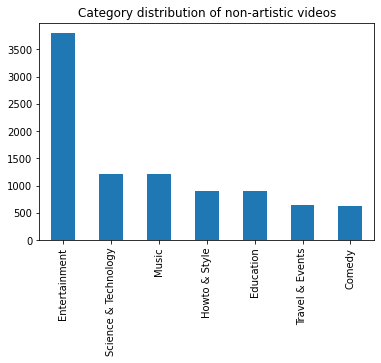

In [12]:
non_art_df = df_meta_16[(df_meta_16.visual_art==0) & (df_meta_16.literary_art==0) & (df_meta_16.performing_art==0)]

plt.figure()
non_art_df.categories.value_counts().plot(kind='bar')
plt.title("Category distribution of non-artistic videos")
plt.show()

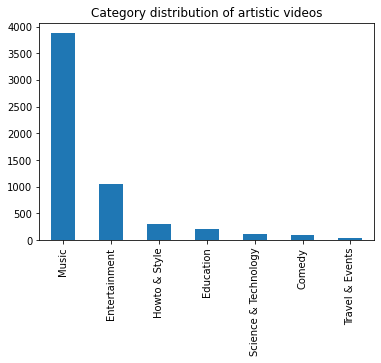

In [13]:
art_df = df_meta_16[~df_meta_16.isin(non_art_df)].dropna()

plt.figure()
art_df.categories.value_counts().plot(kind='bar')
plt.title("Category distribution of artistic videos")
plt.show()

In [25]:
art_df.performing_art.value_counts()

1.0    4884
0.0     817
Name: performing_art, dtype: int64

Using Venn diagram, we can see the distribution of types of art in defined artistic category, as well as see videos with two or all three tags

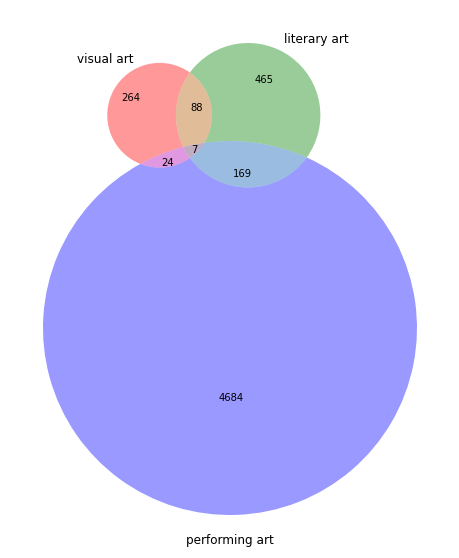

In [28]:
from matplotlib_venn import venn3

vis = art_df[(art_df['visual_art'] == 1)] 
lit = art_df[(art_df['literary_art'] == 1)]
perf = art_df[(art_df['performing_art'] == 1)]

plt.figure(figsize=(10,10))
set1 = set(vis['index'])
set2 = set(lit['index'])
set3 = set(perf['index'])

venn3([set1, set2, set3], ['visual art', 'literary art', 'performing art'])

plt.show()

Check if there is a consistency of uploading artistic videos or if there are some patterns

In [39]:
# Convert upload date to only date format
df_meta_16['upload_date'] = pd.to_datetime(df_meta_16['upload_date'], format='%Y-%m-%d').dt.date
art_df['upload_date'] = pd.to_datetime(art_df['upload_date'], format='%Y-%m-%d').dt.date

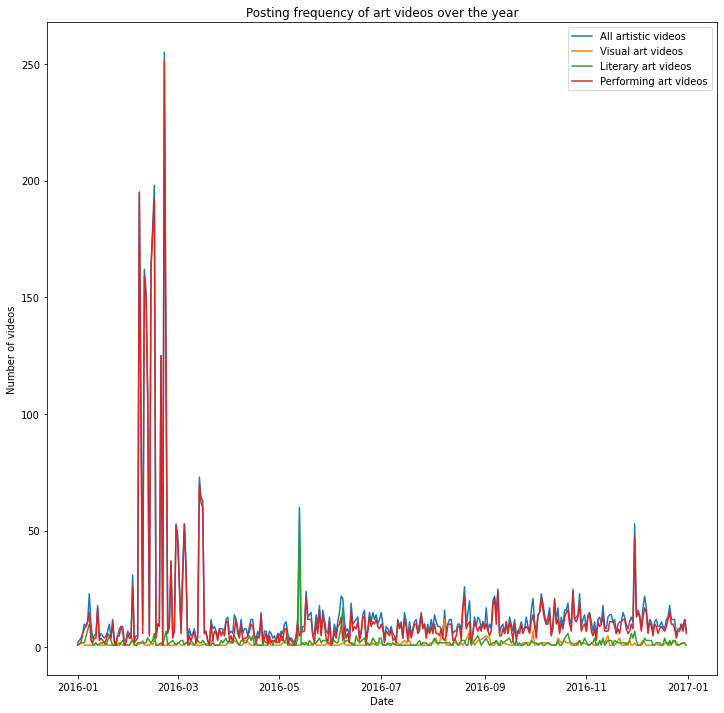

In [58]:
all_art_vid_count_year = art_df.groupby("upload_date").count().channel_id
vis_art_vid_count_year = art_df[art_df.visual_art==1].groupby("upload_date").count().channel_id
lit_art_vid_count_year = art_df[art_df.literary_art==1].groupby("upload_date").count().channel_id
perf_art_vid_count_year = art_df[art_df.performing_art==1].groupby("upload_date").count().channel_id

plt.figure(figsize=(12,12))
plt.plot(all_art_vid_count_year, label="All artistic videos")
plt.plot(vis_art_vid_count_year, label="Visual art videos")
plt.plot(lit_art_vid_count_year, label="Literary art videos")
plt.plot(perf_art_vid_count_year, label="Performing art videos")
plt.legend()
plt.title('Posting frequency of art videos over the year')
plt.xlabel('Date')
plt.ylabel('Number of videos')
plt.show()


In [ ]:
#plt.figure(figsize=(15,15))
#sns.heatmap()
#plt.title("Posting of artistic videos over a year ")
#plt.xlabel('Months')
#plt.ylabel('Number of posted videos')
#plt.show()